# Compute Spectral Indices of Detected Sources

In [1]:
import os
import numpy as np
from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import QTable
import astropy.units as u

import seaborn as sns
import matplotlib.pyplot as plt

## Define Functions

In [2]:
def get_target_pixel(hdu, target_coord_str):
    # Extract the image data and header
    image_header = hdu.header

    # Create a WCS object from the FITS header
    wcs = WCS(image_header)

    # Convert the target coordinate to SkyCoord object
    target_coord = SkyCoord(target_coord_str, unit=(u.hourangle, u.deg))

    # Convert the target coordinate to pixel coordinates
    target_pixel = wcs.all_world2pix(target_coord.ra.deg, target_coord.dec.deg, 0, 0, 1)
    
    # Round the pixel coordinates to the nearest integer
    target_pixel = np.round(target_pixel).astype(int) - np.array([1, 1, 1, 1])

    return target_pixel

def get_cutout(data, cutout, pc):
    """ 
    Get a cutout of the centre of a 2D data array.
    """

    N = data.shape[0]

    nstart0 = max(pc[0] - cutout // 2, 0)
    nend0 = min(pc[0] + cutout // 2 + 1, N)
    nstart1 = max(pc[1] - cutout // 2, 0)
    nend1 = min(pc[1] + cutout // 2 + 1, N)

    return data[nstart0:nend0, nstart1:nend1]

# Define the 2D Gaussian function
def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
    b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
    c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
    g = amplitude * np.exp(- (a * ((x - xo)**2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo)**2)))
    return g.ravel()

def gauss_fit_2d(data, bounds):
    N = data.shape[0]

    # Generate some sample data
    x = np.arange(-N//2, N//2)
    y = np.arange(-N//2, N//2)
    X, Y = np.meshgrid(x, y)

    # Perform the Gaussian fit
    popt, pcov = curve_fit(gaussian_2d, (X, Y), data.ravel(), p0=(0, 0, 0, 5, 5, 0), bounds=bounds)

    # Extract the fitted parameters
    return popt    

def model_spectrum(freq, log_F0, alpha):
    return 10**(log_F0) * (freq / 1.4e9) ** alpha

## Load Data

In [3]:
obsnames = ["QSO-J1427+3312", "QSO-J1429+5447", "QSO-J2318-3113"]
qso_catalog = QTable.read('../tables/Quasar_catalog_Banados+16_Matsuoka+19a_Matsuoka+19b_Wang+18_Wang+19_Reed+19_Yang+20.txt', format='ascii')


obs_dict = {}

for obsname in obsnames:
    catalog_name = list(obsname)
    catalog_name[3] = "_"
    catalog_name = "".join(catalog_name)
    
    qso_data = qso_catalog[qso_catalog["QSO-Name"] ==  catalog_name]

    fluxints = []
    freqs = []
    mad_list = []
    peaks = []

    for i in range(9):
        # read FITS data
        imfits = os.path.join(f"/rds/user/pmk46/hpc-work/19A-056/imaging/{obsname}/clean/", f"{obsname}-res.im-000{i}-image.fits")
        hdu = fits.open(imfits)[0]
        header = hdu.header
        image_data = hdu.data[0, 0]
        
        # get image cutout
        Nsmall = 9
        ra = qso_data["RA"].value[0]
        dec = qso_data["Dec"].value[0]
        pc = get_target_pixel(hdu, f"{ra} {dec}")[[0, 1]]
        peak = image_data[pc[0], pc[1]]
        image_data_small = get_cutout(image_data, Nsmall, pc)
        image_data = get_cutout(image_data, 128, pc)
        mad_list.append(np.median(1.4826 * np.abs(image_data - np.median(image_data))))

        beam = header["BMIN"] * header["BMAJ"] / (header["CDELT2"] * 2.355)**2
        amplitude, x_mean, y_mean, x_stddev, y_stddev, theta = gauss_fit_2d(image_data_small, bounds=([-1e5, -4, -4, 1, 1, -np.pi/4], [1e5, 4, 4, 8, 8, np.pi/4]))
        fluxint = (amplitude * x_stddev * y_stddev / beam)
        
        freqs.append(header["CRVAL3"])
        fluxints.append(fluxint)
        peaks.append(peak)

    # Perform spectral index fit
    params, cov = curve_fit(model_spectrum, freqs, peaks, sigma=mad_list)
    log_F0, alpha = params
    F0 = 10**log_F0
    reg_band = lambda freq, nsig: nsig * np.sqrt(cov[0, 0] + np.log10(freq / 1.4e9) * (np.log10(freq / 1.4e9) * cov[1, 1] + cov[0, 1] + cov[1, 0]))
    obs_dict.update({obsname: (freqs, fluxints, peaks, mad_list, F0, alpha, cov, reg_band)})



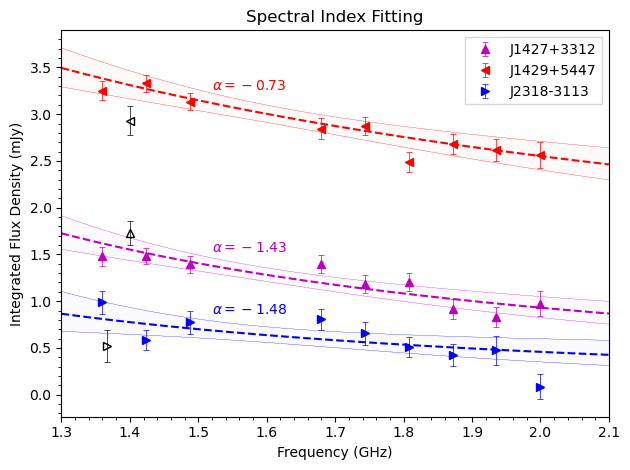

In [21]:
colors = ["m", "r", "b"]
markers = ["^", "<", ">"]

for obsname, color, marker in zip(obs_dict, colors, markers):
    (freqs, fluxints, peaks, mad_list, F0, alpha, cov, reg_band) = obs_dict[obsname]
    sig_alpha = cov[1, 1]

    x = np.linspace(1.3, 2.1, 1000) * 1e9
    y = model_spectrum(x, np.log10(F0), alpha)

    plt.errorbar(np.array(freqs) / 1e9, np.array(fluxints) * 1e3, yerr=np.array(mad_list) * 1e3, fmt=marker, color=color, label=obsname[4:], capsize=2, capthick=.5, elinewidth=.5)
    plt.plot(x / 1e9, y * 1e3, color=color, linestyle="--")
    plt.plot(x / 1e9, y * 10**reg_band(x, 2) * 1e3, color=color, linestyle="-", linewidth=.2)
    plt.plot(x / 1e9, y / 10**reg_band(x, 2) * 1e3, color=color, linestyle="-", linewidth=.2)
    plt.fill_between(x / 1e9, y * 10**reg_band(x, 2) * 1e3, y / 10**reg_band(x, 2) * 1e3, color=color, alpha=0.02)

    plt.text(1.52, model_spectrum(1.56e9, np.log10(F0), alpha) * 1e3 + 0.2 , rf"$\alpha={alpha.round(2)}$", color=color)

plt.errorbar(1.4, 1.730, yerr=0.131, fmt="^", color="k", fillstyle="none", capsize=2, capthick=.5, elinewidth=.5, markersize=6)
plt.errorbar(1.4, 2.930, yerr=0.152, fmt="<", color="k", fillstyle="none", capsize=2, capthick=.5, elinewidth=.5, markersize=6)
plt.errorbar(1.367, 0.52, yerr=0.17, fmt=">", color="k", fillstyle="none", capsize=2, capthick=.5, elinewidth=.5, markersize=6)

plt.xlim([1.3, 2.1])
plt.xlabel("Frequency (GHz)")
plt.ylabel("Integrated Flux Density (mJy)")
plt.title("Spectral Index Fitting")
plt.minorticks_on()
plt.legend(fancybox=False)
plt.tight_layout()
plt.savefig("../../plots/spix.png", dpi=600)

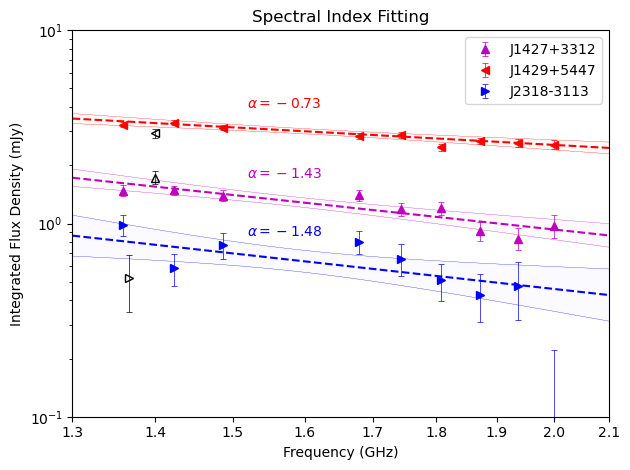

In [12]:
colors = ["m", "r", "b"]
markers = ["^", "<", ">"]

for obsname, color, marker in zip(obs_dict, colors, markers):
    (freqs, fluxints, peaks, mad_list, F0, alpha, cov, reg_band) = obs_dict[obsname]
    sig_alpha = cov[1, 1]

    x = np.linspace(1.3, 2.1, 1000) * 1e9
    y = model_spectrum(x, np.log10(F0), alpha)

    plt.errorbar(np.array(freqs) / 1e9, np.array(fluxints) * 1e3, yerr=np.array(mad_list) * 1e3, fmt=marker, color=color, label=obsname[4:], capsize=2, capthick=.5, elinewidth=.5)
    plt.plot(x / 1e9, y * 1e3, color=color, linestyle="--")
    plt.plot(x / 1e9, y * 10**reg_band(x, 2) * 1e3, color=color, linestyle="-", linewidth=.2)
    plt.plot(x / 1e9, y / 10**reg_band(x, 2) * 1e3, color=color, linestyle="-", linewidth=.2)
    plt.fill_between(x / 1e9, y * 10**reg_band(x, 2) * 1e3, y / 10**reg_band(x, 2) * 1e3, color=color, alpha=0.02)

    plt.text(1.52, model_spectrum(1.56e9, np.log10(F0), alpha) * 1.3e3, rf"$\alpha={alpha.round(2)}$", color=color)

plt.errorbar(1.4, 1.730, yerr=0.131, fmt="^", color="k", fillstyle="none", capsize=2, capthick=.5, elinewidth=.5)
plt.errorbar(1.4, 2.930, yerr=0.152, fmt="<", color="k", fillstyle="none", capsize=2, capthick=.5, elinewidth=.5)
plt.errorbar(1.367, 0.52, yerr=0.17, fmt=">", color="k", fillstyle="none", capsize=2, capthick=.5, elinewidth=.5)

plt.xscale("log")
plt.yscale("log")
plt.xlim([1.3, 2.1])
plt.ylim([1e-1, 1e1])
plt.xlabel("Frequency (GHz)")
plt.ylabel("Integrated Flux Density (mJy)")
plt.title("Spectral Index Fitting")
plt.minorticks_on()
plt.legend()
plt.xticks(np.arange(1.3, 2.2, 0.1), np.arange(1.3, 2.2, 0.1).round(1))
plt.tight_layout()